In [206]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [207]:
items=pd.read_csv("C:/Users/chenl/Data Science prep/data/item_to_id - Clustering Grocery Items.csv")
purchases=pd.read_csv("C:/Users/chenl/Data Science prep/data/purchase_history - Clustering Grocery Items.csv")
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 900.0+ bytes


In [208]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [209]:
purchases.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [210]:
purchase["user_id"].nunique()

24885

In [211]:
# process: merge and explode
purchases["id"]=purchases["id"].apply( lambda x: x.split(","))
purchase=purchases.explode("id")
items["Item_id"]=items["Item_id"].astype("str")
purchase=pd.merge(purchase,items,how="left",left_on="id",right_on="Item_id")
purchase=purchase[["user_id","Item_name","Item_id"]]
purchase

,user_id,Item_name,Item_id
0,222087,dishwashing,27
1,222087,spaghetti sauce,26
2,1343649,poultry,6
3,1343649,pork,47
4,1343649,beef,17
...,...,...,...
319990,517744,juice,38
319991,517744,coffee,43
319992,517744,canned vegetables,28
319993,517744,cherries,25


# 1
the customer who bought the most items overall in her lifetime; 

for each item, the customer who bought that product the most


In [212]:
#  2 pd: total count & item's top count user id
print("total spending user")
total_spend=purchase.groupby("user_id")["Item_id"].count().reset_index().sort_values(by="Item_id")
print(total_spend.tail(5))

#
print('top user per product')
spend_per_procduct=purchase.groupby(["Item_name","user_id"])["Item_id"].count().reset_index()
spend_per_procduct.loc[spend_per_procduct.groupby("Item_name")["Item_id"].idxmax()]

total spending user
      user_id  Item_id
6291   377284       63
6623   397623       64
9918   599172       64
6111   367872       70
4445   269335       72
top user per product


,Item_name,user_id,Item_id
306,aluminum foil,143741,3
3694,apples,109578,4
11216,baby items,5289,3
17786,bagels,653800,4
28565,bananas,1218645,4
31978,beef,366155,4
38032,berries,38872,4
45928,broccoli,31625,4
54278,butter,151926,3
59834,canned vegetables,204624,4


# 2 clustering - similar products
Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. Each item can belong to just one cluster.

In [213]:
# create matrix
from itertools import combinations
from collections import Counter

# use counter and combination to get the occurance of each pair
pair_counts=Counter()
for transaction in purchases["id"]:
    pair_counts.update(combinations(sorted(transaction),2))
co_occurance_pd=pd.DataFrame(pair_counts.items(),columns=["pair","count"])
# replace pair column with 2
co_occurance_pd[["Product1", "Product2"]] = pd.DataFrame(co_occurance_pd["pair"].tolist(), index=co_occurance_pd.index) #
co_occurance_pd = co_occurance_pd.drop(columns=["pair"])
# co_occurance_pd
# Pivot into a square matrix
all_products = sorted(set(co_occurance_pd["Product1"]) | set(co_occurance_pd["Product2"])) # ensure both column and row contain all product id
co_occurrence_matrix = co_occurance_pd.pivot(index="Product1", columns="Product2", values="count").fillna(0)
co_occurrence_matrix = co_occurrence_matrix.reindex(index=all_products, columns=all_products, fill_value=0)
# co_occurrence_matrix
# Symmetrize the matrix so that the pair count is same from the other direction (A-B = B-A)
co_occurrence_matrix = co_occurrence_matrix + co_occurrence_matrix.T
co_occurrence_matrix


Product2,1,10,11,12,13,14,15,16,17,18,...,44,45,46,47,48,5,6,7,8,9
Product1,,,,,,,,,,,,,,,,,,,,,
1,0.0,2262.0,895.0,872.0,2206.0,1524.0,843.0,1539.0,2218.0,1636.0,...,2316.0,2277.0,2298.0,2279.0,1474.0,870.0,2227.0,931.0,1484.0,2301.0
10,2262.0,0.0,704.0,809.0,2106.0,1428.0,828.0,1415.0,2119.0,1527.0,...,3297.0,3268.0,2202.0,2085.0,1450.0,679.0,2074.0,845.0,1443.0,2126.0
11,895.0,704.0,0.0,243.0,674.0,440.0,271.0,477.0,679.0,476.0,...,681.0,670.0,678.0,693.0,443.0,397.0,684.0,278.0,458.0,699.0
12,872.0,809.0,243.0,0.0,821.0,582.0,307.0,545.0,835.0,592.0,...,811.0,871.0,782.0,838.0,544.0,286.0,830.0,349.0,546.0,840.0
13,2206.0,2106.0,674.0,821.0,0.0,1418.0,807.0,1452.0,2063.0,1489.0,...,2181.0,2107.0,2077.0,2092.0,1450.0,678.0,2069.0,815.0,1452.0,2108.0
14,1524.0,1428.0,440.0,582.0,1418.0,0.0,522.0,1486.0,1362.0,937.0,...,1433.0,1404.0,1401.0,1420.0,1496.0,420.0,1445.0,530.0,1481.0,1388.0
15,843.0,828.0,271.0,307.0,807.0,522.0,0.0,515.0,817.0,605.0,...,838.0,803.0,807.0,818.0,516.0,262.0,816.0,585.0,550.0,856.0
16,1539.0,1415.0,477.0,545.0,1452.0,1486.0,515.0,0.0,1425.0,990.0,...,1399.0,1440.0,1465.0,1393.0,1575.0,452.0,1387.0,512.0,1529.0,1464.0
17,2218.0,2119.0,679.0,835.0,2063.0,1362.0,817.0,1425.0,0.0,1486.0,...,2126.0,2148.0,2108.0,3333.0,1419.0,664.0,3327.0,832.0,1417.0,2079.0


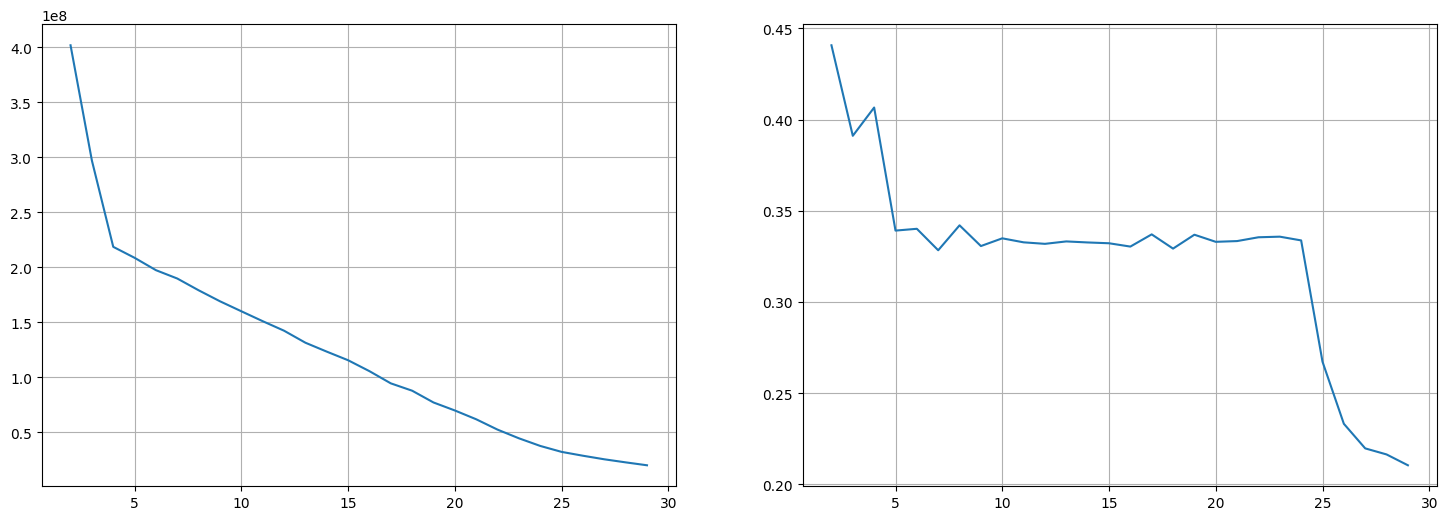

In [214]:
# clustering, try k-mean, ideally scaler applied would be better for model to converge
# find optimal clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusters= range(2,30)
inertias=[]
silhouettes=[]
for n in clusters:
    kmeans=KMeans(n_clusters=n,random_state=100)
    kmeans=kmeans.fit(co_occurrence_matrix)
    label=kmeans.predict(co_occurrence_matrix)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(co_occurrence_matrix,label))
    
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
ax[0].plot(clusters,inertias,label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, label='Silhouette Coefficient')
ax[1].grid(True)
plt.show()

# <6 cluster is optimal

In [215]:
# build model and predict clusters
kmeans=KMeans(n_clusters=5,random_state=100)
kmeans.fit(co_occurrence_matrix)
label=kmeans.predict(co_occurrence_matrix)
co_occurrence_matrix["cluster"]=label
co_occurrence_matrix = co_occurrence_matrix.reset_index()
merged_df = pd.merge(co_occurrence_matrix[["Product1","cluster"]], items, how="left", left_on="Product1", right_on="Item_id")
merged_df.sort_values(by="cluster")

,Product1,cluster,Item_name,Item_id
0,1,0,sugar,1
39,45,0,cauliflower,45
25,32,0,apples,32
12,20,0,grapefruit,20
47,9,0,soda,9
4,13,0,bagels,13
26,33,1,toilet paper,33
45,7,1,sandwich bags,7
43,5,1,waffles,5
33,4,1,baby items,4


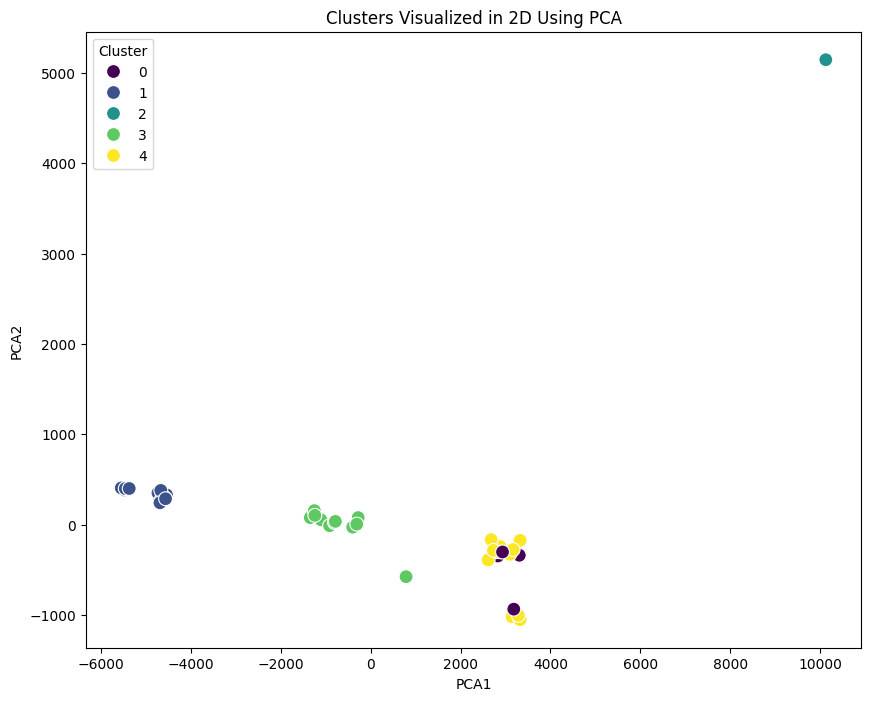

In [216]:
from sklearn.decomposition import PCA
feature_matrix = co_occurrence_matrix.drop(columns=["cluster"])

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(feature_matrix)

# Add the reduced dimensions to the DataFrame
merged_df["PCA1"] = reduced_data[:, 0]
merged_df["PCA2"] = reduced_data[:, 1]

# Scatter plot for clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="cluster", data=merged_df, palette="viridis", s=100
)
plt.title("Clusters Visualized in 2D Using PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()
